# Sound Event Classification

## Requirements

In [1]:
from google.colab import files
uploaded = files.upload()

Saving requirements.txt to requirements (2).txt


In [2]:
%pip install -r requirements.txt

## Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
import IPython.display as ipd
import tqdm
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
plt.style.use("seaborn-v0_8")

from audiomentations import AddGaussianSNR, PitchShift, TimeStretch, ApplyImpulseResponse
from pedalboard import Pedalboard, Compressor

import warnings


In [4]:
warnings.filterwarnings('ignore') # run to suppress warnings

## Dataset

In [ ]:
!wget https://mcdermottlab.mit.edu/Reverb/IRMAudio/Audio.zip
!unzip Audio.zip

Required [ESC-50 Dataset](https://github.com/karolpiczak/ESC-50/archive/master.zip)

In [ ]:
!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
!unzip master.zip

### Loading of the dataset of the metadata and dataset analysis

In [5]:
fn_csv = 'ESC-50-master/meta/esc50.csv'

ds_files = []  # File list
ds_labels = []  # Class list

ds = pd.read_csv(fn_csv)
ds.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [6]:
#unique class labels
unique_classes = ds['category'].unique()
print("Unique classes:", unique_classes)

# Check the number of unique class labels
print("Count:", len(unique_classes))

# Filling the lists with filenames and labels
ds_files = ds['filename'].values
pure_ds_labels = ds['category'].values

Unique classes: ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'car_horn' 'crackling_fire' 'helicopter'
 'drinking_sipping' 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing'
 'crying_baby' 'hand_saw' 'coughing' 'glass_breaking' 'snoring'
 'toilet_flush' 'pig' 'washing_machine' 'clock_tick' 'sneezing' 'rooster'
 'sea_waves' 'siren' 'cat' 'door_wood_creaks' 'crickets']
Count: 50


# Pre-processing

Required [MIT Acoustical Reverberation Scene Statistics Survey](https://mcdermottlab.mit.edu/Reverb/IRMAudio/Audio.zip)

We decided to use audiomentations instead of the PyTorch one in order to have compressors.
-	Add different background noises with different SNRs
-	Pitch shifting
-	Time stretching
-	Dynamic range compression
-	Convolution with impulse responses

Background noise

In [7]:
def addGaussianNoise(signal, sr, min_snr_db, max_snr_db, activation_prob):
    """
    Adds Gaussian noise to the audio signal with a specified SNR range and activation probability.
    Args:
        signal (np.ndarray): The audio signal to augment.
        sr (int): Sample rate of the audio signal.
        min_snr_db (float): Minimum SNR in dB.
        max_snr_db (float): Maximum SNR in dB.
        activation_prob (float): Probability of applying the augmentation.
    Returns:
        np.ndarray: The augmented audio signal with Gaussian noise added.
    """

    transform = AddGaussianSNR(
        min_snr_db=min_snr_db,
        max_snr_db=max_snr_db,
        p=activation_prob
    )
    augmented_signal = transform(samples=signal, sample_rate=sr)
    return augmented_signal

Pitch Shifting

In [8]:
def pitchShifter(signal, sr, min_semitones, max_semitones, activation_prob):
    """
    Shifts the pitch of the audio signal by a random number of semitones within a specified range.
    Args:
        signal (np.ndarray): The audio signal to augment.
        sr (int): Sample rate of the audio signal.
        min_semitones (int): Minimum number of semitones to shift.
        max_semitones (int): Maximum number of semitones to shift.
        activation_prob (float): Probability of applying the augmentation.
    Returns:
        np.ndarray: The augmented audio signal with pitch shifted.
    """

    transform = PitchShift(
        min_semitones=min_semitones,
        max_semitones=max_semitones,
        p=activation_prob
    )
    augmented_signal = transform(samples=signal, sample_rate=sr)
    return augmented_signal

Time Stretching

In [9]:
def timeStretcher(signal, sr, min_rate, max_rate, activation_prob, leave_length_unchanged=True):
    """
    Stretches or compresses the audio signal in time by a random factor within a specified range.
    Args:
        signal (np.ndarray): The audio signal to augment.
        sr (int): Sample rate of the audio signal.
        min_rate (float): Minimum stretch/compression rate.
        max_rate (float): Maximum stretch/compression rate.
        activation_prob (float): Probability of applying the augmentation.
        leave_length_unchanged (bool): If True, the length of the output signal will be the same as the input.
    Returns:
        np.ndarray: The augmented audio signal with time-stretching applied.
    """

    transform = TimeStretch(
        min_rate=min_rate,
        max_rate=max_rate,
        leave_length_unchanged=leave_length_unchanged,
        p=activation_prob
    )

    augmented_sound = transform(signal, sample_rate=sr)
    return augmented_sound

Compressor

In [10]:
def compressor(signal, sr, threshold_db, ratio, attack_ms, release_ms):
    """
    Applies a compressor to the audio signal.
    Args:
        signal (np.ndarray): The audio signal to compress.
        sr (int): Sample rate of the audio signal.
        threshold_db (float): Threshold in dB for the compressor.
        ratio (float): Compression ratio.
        attack_ms (int): Attack time in milliseconds.
        release_ms (int): Release time in milliseconds.
    Returns:
        np.ndarray: The compressed audio signal.
    """

    original_dtype = signal.dtype

    if signal.ndim == 1:
        signal = np.expand_dims(signal, axis=1)  # from [samples] to [samples, 1]

    signal = signal.T  # from [samples, channels] to [channels, samples]

    board = Pedalboard([
        Compressor(threshold_db=threshold_db, ratio=ratio, attack_ms=attack_ms, release_ms=release_ms),
    ])

    processed = board(signal, sr)  # output shape: [channels, samples]

    # Back to [samples, channels]
    augmented_sound = processed.T

    # Convert to the original dtype
    if augmented_sound.dtype != original_dtype:
        if np.issubdtype(original_dtype, np.integer):
            max_val = np.max(np.abs(augmented_sound))
            if max_val > 0:
                normalized = augmented_sound / max_val
            else:
                normalized = augmented_sound
            info = np.iinfo(original_dtype)
            scaled = (normalized * info.max).clip(info.min, info.max).astype(original_dtype)
            augmented_sound = scaled
        else:
            augmented_sound = augmented_sound.astype(original_dtype)

    augmented_sound = np.squeeze(augmented_sound)  # Remove any singleton dimensions

    return augmented_sound

Impulse respones convolution

In [11]:
def convolver(signal, sr, activation_prob):
    """
    Applies an impulse response to the audio signal to simulate reverberation.
    Args:
        signal (np.ndarray): The audio signal to convolve.
        sr (int): Sample rate of the audio signal.
        activation_prob (float): Probability of applying the convolution.
    Returns:
        np.ndarray: The augmented audio signal with convolution applied.
    """

    transform = ApplyImpulseResponse(ir_path="Audio", p=activation_prob)

    augmented_sound = transform(signal, sample_rate=sr)

    return augmented_sound

Pre-processing for a single track

In [12]:
def preProcessingSignal(
    signal, sr,
    label,
    gaussianParameters=None,
    pitchParameters=None,
    timeStretchParameters=None,
    compressorParameters=None,
    convolverParameters=None
    ):
    """
    Preprocesses the audio signal by applying various augmentations based on the provided parameters.
    Args:
        signal (np.ndarray): The audio signal to preprocess.
        sr (int): Sample rate of the audio signal.
        label (str): Label for the audio signal.
        gaussianParameters (tuple, optional): Parameters for Gaussian noise augmentation (min_snr_db, max_snr_db, activation_prob).
        pitchParameters (tuple, optional): Parameters for pitch shifting (min_semitones, max_semitones, activation_prob).
        timeStretchParameters (tuple, optional): Parameters for time stretching (min_rate, max_rate, activation_prob, leave_length_unchanged).
        compressorParameters (tuple, optional): Parameters for compression (threshold_db, ratio, attack_ms, release_ms).
        convolverParameters (float, optional): Probability of applying convolution with impulse response.
    Returns:
        tuple: A tuple containing a list of processed signals and their corresponding labels.
    """

    signals = []
    labels = []

    signals.append(signal)
    labels.append(label)

    if gaussianParameters is not None:
        min_snr_db, max_snr_db, activation_prob = gaussianParameters
        signal_1 = addGaussianNoise(signal, sr, min_snr_db, max_snr_db, activation_prob)
        #print(f"Added Gaussian noise with SNR range: {min_snr_db} to {max_snr_db} dB, activation probability: {activation_prob}")
        signals.append(signal_1)
        labels.append(label)

    if pitchParameters is not None:
        min_semitones, max_semitones, activation_prob = pitchParameters
        signal_2 = pitchShifter(signal, sr, min_semitones, max_semitones, activation_prob)
        #print(f"Pitch shifted by {min_semitones} to {max_semitones} semitones, activation probability: {activation_prob}")
        signals.append(signal_2)
        labels.append(label)

    if timeStretchParameters is not None:
        min_rate, max_rate, activation_prob, leave_length_unchanged = timeStretchParameters
        signal_3 = timeStretcher(signal, sr, min_rate, max_rate, activation_prob, leave_length_unchanged)
        #print(f"Time stretched/compressed by a factor of {min_rate} to {max_rate}, activation probability: {activation_prob}, leave length unchanged: {leave_length_unchanged}")
        signals.append(signal_3)
        labels.append(label)

    if compressorParameters is not None:
        threshold_db, ratio, attack_ms, release_ms = compressorParameters
        signal_4 = compressor(signal, sr, threshold_db, ratio, attack_ms, release_ms)
        #print(f"Applied compressor with threshold: {threshold_db} dB, ratio: {ratio}, attack: {attack_ms} ms, release: {release_ms} ms")
        signals.append(signal_4)
        labels.append(label)

    if convolverParameters is not None:
        activation_prob = convolverParameters
        signal_5 = convolver(signal, sr, activation_prob)
        #print(f"Applied convolution with impulse response, activation probability: {activation_prob}")
        signals.append(signal_5)
        labels.append(label)

    return signals, labels



Pre-processing for the entire dataset

In [13]:
def preProcessingDataset(
    Xdata, sr,
    Ydata,
    gaussianParameters=None,
    pitchParameters=None,
    timeStretchParameters=None,
    compressorParameters=None,
    convolverParameters=None
):
    """
    Preprocesses a dataset of audio signals by applying various augmentations based on the provided parameters.
    Args:
        Xdata (list): List of audio signals to preprocess.
        sr (int): Sample rate of the audio signals.
        Ydata (list): List of labels corresponding to the audio signals.
        gaussianParameters (tuple, optional): Parameters for Gaussian noise augmentation (min_snr_db, max_snr_db, activation_prob).
        pitchParameters (tuple, optional): Parameters for pitch shifting (min_semitones, max_semitones, activation_prob).
        timeStretchParameters (tuple, optional): Parameters for time stretching (min_rate, max_rate, activation_prob, leave_length_unchanged).
        compressorParameters (tuple, optional): Parameters for compression (threshold_db, ratio, attack_ms, release_ms).
        convolverParameters (float, optional): Probability of applying convolution with impulse response.
    Returns:
        tuple: A tuple containing a numpy array of processed signals and a numpy array of their corresponding labels.
    """

    all_signals = []
    all_labels = []

    for signal, label in zip(Xdata, Ydata):
        signals, labels = preProcessingSignal(
            signal, sr, label,
            gaussianParameters,
            pitchParameters,
            timeStretchParameters,
            compressorParameters,
            convolverParameters
        )
        all_signals.extend(signals)
        all_labels.extend(labels)

    all_signals = np.asarray(all_signals)
    all_labels = np.asarray(all_labels)

    return all_signals, all_labels

# Feature extraction

Nos cargamos todos los signales

In [14]:
pure_signals = []
audio_folder = "ESC-50-master/audio/"

for file in ds_files:
    filepath = os.path.join(audio_folder, file)
    pure_signal, sr = librosa.load(filepath)
    pure_signals.append(pure_signal)

Check pre pre-processing

In [15]:
print(f"Number of audio files: {len(pure_signals)}")
print(f"Number of audio labels: {len(pure_ds_labels)}")

Number of audio files: 2000
Number of audio labels: 2000


Lista -> np

In [16]:
pure_signals_array = np.asarray(pure_signals)

# Transform the labels to numbers
label_mapping = {label: idx for idx, label in enumerate(dict.fromkeys(pure_ds_labels))}
numerical_labels = np.array([label_mapping[label] for label in pure_ds_labels])

Ydata = np.asarray(numerical_labels) # Aquí, hay todas las clases

print('Pure signals length: {} \nYata shape: {}'.format(pure_signals_array.shape, Ydata.shape))

Pure signals length: (2000, 110250) 
Yata shape: (2000,)


Piccolo test esemplificativo per vedere se la funzione per il data augmentation è ok

In [17]:
signal_example = pure_signals_array[0]
label_example = Ydata[0]

signal_example_aug, label_example_aug = preProcessingSignal(
    signal=signal_example,
    sr=sr,
    label=label_example,
    gaussianParameters = (5, 40, 1),
    pitchParameters = (-5, 5, 1),
    timeStretchParameters = (0.8, 1.25, 1, True),
    compressorParameters = (-20, 4.0, 10.0, 100.0),
    convolverParameters = 1
)

type_of_processing = [
    "Original",
    "Gaussian Noise",
    "Pitch Shift",
    "Time Stretch",
    "Compressor",
    "Convolver"
]

# Listen to the first 5 augmented audio files
for i in range(6):
    print(type_of_processing[i])
    ipd.display(ipd.Audio(data=signal_example_aug[i], rate=sr))

Original


Gaussian Noise


Pitch Shift


Time Stretch


Compressor


Convolver


### no cross v

In [18]:
seed = 42 # We set a seed for reproducibility

X_train, X_temp, y_train, y_temp = train_test_split(pure_signals_array, Ydata, train_size=0.7, random_state=seed, stratify=Ydata) #we use stratify to keep the same distribution of classes in the training set

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=seed, stratify=y_temp)  #we use stratify to keep the same distribution of classes in the validation and test sets
print('X_train shape: {} \nX_val shape: {} \nX_test shape: {} \ny_train shape: {} \ny_val shape: {} \ny_test shape: {} \n'.format(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape))


X_train shape: (1400, 110250) 
X_val shape: (400, 110250) 
X_test shape: (200, 110250) 
y_train shape: (1400,) 
y_val shape: (400,) 
y_test shape: (200,) 



augmentation on train set

In [19]:
X_train_aug, y_train_aug = preProcessingDataset(
    Xdata=X_train,
    sr=sr,
    Ydata=y_train,
    gaussianParameters = (5, 40, 1),
    pitchParameters = (-5, 5, 1),
    timeStretchParameters = (0.8, 1.25, 1, True),
    compressorParameters = (-20, 4.0, 10.0, 100.0),
    convolverParameters = 1
)

In [20]:
print('X_train_aug shape: {} \nX_val shape: {} \nX_test shape: {} \ny_train_aug shape: {} \ny_val shape: {} \ny_test shape: {} \n'.format(X_train_aug.shape, X_val.shape, X_test.shape, y_train_aug.shape, y_val.shape, y_test.shape))

X_train_aug shape: (8400, 110250) 
X_val shape: (400, 110250) 
X_test shape: (200, 110250) 
y_train_aug shape: (8400,) 
y_val shape: (400,) 
y_test shape: (200,) 



feature extraction

In [21]:
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [22]:
mel_spegrams_test = []

for signal in X_test:
    mel_spec = calculate_melsp(signal)
    mel_spegrams_test.append(mel_spec)

X_test_fe = np.array(mel_spegrams_test)
X_test_exp = np.expand_dims(X_test_fe, axis=-1)
print('X_test_exp shape: {} \ny_test shape: {}'.format(X_test_exp.shape, y_test.shape))

X_test_exp shape: (200, 128, 862, 1) 
y_test shape: (200,)


In [23]:
mel_spegrams_train = []

for signal in X_train_aug:
    mel_spec = calculate_melsp(signal)
    mel_spegrams_train.append(mel_spec)

X_train_aug_fe = np.array(mel_spegrams_train)
X_train_exp = np.expand_dims(X_train_aug_fe, axis=-1)
print('X_train_exp shape: {} \ny_train_aug shape: {}'.format(X_train_exp.shape, y_train_aug.shape))

X_train_exp shape: (8400, 128, 862, 1) 
y_train_aug shape: (8400,)


In [24]:
mel_spegrams_val = []

for signal in X_val:
    mel_spec = calculate_melsp(signal)
    mel_spegrams_val.append(mel_spec)

X_val_fe = np.array(mel_spegrams_val)
X_val_exp = np.expand_dims(X_val_fe, axis=-1)
print('X_val_exp shape: {} \ny_val shape: {}'.format(X_val_exp.shape, y_val.shape))

X_val_exp shape: (400, 128, 862, 1) 
y_val shape: (400,)


# model4jose

In [25]:
input_shape = X_train_exp.shape[1:]
print('INPUT SHAPE:',input_shape)

model_2D=tf.keras.models.Sequential()
model_2D.add(tf.keras.Input(shape=input_shape))

#1st Conv 2D layer
model_2D.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name='CONV1'))
model_2D.add(tf.keras.layers.MaxPooling2D((2,2), padding='same', name='MP1'))
model_2D.add(tf.keras.layers.BatchNormalization())

#2nd Conv layer
model_2D.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name='CONV2'))
model_2D.add(tf.keras.layers.MaxPooling2D((2,2), padding='same', name='MP2'))
model_2D.add(tf.keras.layers.BatchNormalization())

#3rd Conv layer
model_2D.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name='CONV3'))
model_2D.add(tf.keras.layers.MaxPooling2D((2,2), padding='same', name='MP3'))
model_2D.add(tf.keras.layers.BatchNormalization())
model_2D.add(tf.keras.layers.Flatten(name='FLATTEN'))

#4th Dense Layer
model_2D.add(tf.keras.layers.Dense(32, activation='relu', name='DENSE'))

#output layer
model_2D.add(tf.keras.layers.Dense(50, activation='softmax', name='SOFTMAX'))
model_2D.summary()

INPUT SHAPE: (128, 862, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CONV1 (Conv2D)                  │ (None, 128, 862, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MP1 (MaxPooling2D)              │ (None, 64, 431, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 431, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV2 (Conv2D)                  │ (None, 64, 431, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MP2 (MaxPooling2D)              │ (None, 32, 216, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 216, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV3 (Conv2D)                  │ (None, 32, 216, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MP3 (MaxPooling2D)              │ (None, 16, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 108, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FLATTEN (Flatten)               │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DENSE (Dense)                   │ (None, 32)             │     1,769,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SOFTMAX (Dense)                 │ (None, 50)             │         1,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,778,530 (6.78 MB)

 Trainable params: 1,778,402 (6.78 MB)

 Non-trainable params: 128 (512.00 B)

In [26]:
# CSVLogger
csv_logger = CSVLogger('training_2D_CNN.log', append=False)

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

#model checkpoint
model_name = 'CNN_2D_model.h5'
model_checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, verbose=1)

#store all these callbacks in a list, Callback list
callbacks = [csv_logger, early_stopping, model_checkpoint]

# Compile the model
learning_rate=0.001
batch_size=32
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_2D.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
history_2D = model_2D.fit(X_train_exp, y_train_aug, batch_size=batch_size, epochs=300, validation_data=(X_val_exp, y_val), callbacks=callbacks)

Epoch 1/300
260/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5452 - loss: 1.4204
Epoch 1: val_accuracy did not improve from 0.23250
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5452 - loss: 1.4203 - val_accuracy: 0.2175 - val_loss: 5.6784
Epoch 2/300
259/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5479 - loss: 1.3757
Epoch 2: val_accuracy did not improve from 0.23250
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5480 - loss: 1.3758 - val_accuracy: 0.2075 - val_loss: 5.5593
Epoch 3/300
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5745 - loss: 1.3701
Epoch 3: val_accuracy did not improve from 0.23250
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5744 - loss: 1.3701 - val_accuracy: 0.2225 - val_loss: 5.3321
Epoch 4/300
260/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5716 - loss: 1.3467
Epoch 4: val_accuracy did not improve from 0.23250
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5717 - loss: 1.3465 - val_accuracy

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6161 - loss: 1.2350 - val_accuracy: 0.2550 - val_loss: 5.8516
Epoch 7/300
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6118 - loss: 1.2315
Epoch 7: val_accuracy did not improve from 0.25500
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6118 - loss: 1.2317 - val_accuracy: 0.2500 - val_loss: 6.1076
Epoch 8/300
260/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6281 - loss: 1.2134
Epoch 8: val_accuracy did not improve from 0.25500
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6280 - loss: 1.2133 - val_accuracy: 0.2250 - val_loss: 6.2925
Epoch 9/300
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6367 - loss: 1.1582
Epoch 9: val_accuracy did not improve from 0.25500
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6366 - loss: 1.1584 - val_accuracy: 0.2375 - val_loss: 6.4741
Epoch 10/300
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6478 - loss: 1.1255
Epoch 10: val_accuracy

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7022 - loss: 0.9773 - val_accuracy: 0.2675 - val_loss: 7.2859
Epoch 16/300
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7103 - loss: 0.9672
Epoch 16: val_accuracy did not improve from 0.26750
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7102 - loss: 0.9673 - val_accuracy: 0.2650 - val_loss: 7.5608
Epoch 17/300
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7028 - loss: 0.9700
Epoch 17: val_accuracy did not improve from 0.26750
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7029 - loss: 0.9697 - val_accuracy: 0.2500 - val_loss: 7.9992
Epoch 18/300
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7161 - loss: 0.9089
Epoch 18: val_accuracy did not improve from 0.26750
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7161 - loss: 0.9089 - val_accuracy: 0.2525 - val_loss: 7.6661
Epoch 19/300
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7295 - loss: 0.8473
Epoch 19: val_ac

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7773 - loss: 0.7223 - val_accuracy: 0.2725 - val_loss: 9.4372
Epoch 32/300
260/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7691 - loss: 0.7093
Epoch 32: val_accuracy did not improve from 0.27250
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7691 - loss: 0.7096 - val_accuracy: 0.2550 - val_loss: 9.2401
Epoch 33/300
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7805 - loss: 0.6971
Epoch 33: val_accuracy did not improve from 0.27250
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7804 - loss: 0.6973 - val_accuracy: 0.2500 - val_loss: 10.4918


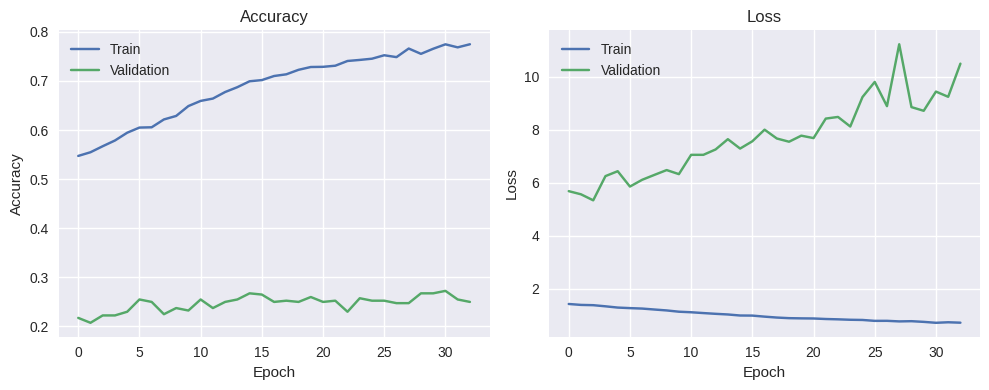

Best validation accuracy:  0.27250000834465027
Epoch for which we get the best validation accuracy:  30
Test loss: 7.225256443023682
Test accuracy: 0.28999999165534973
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


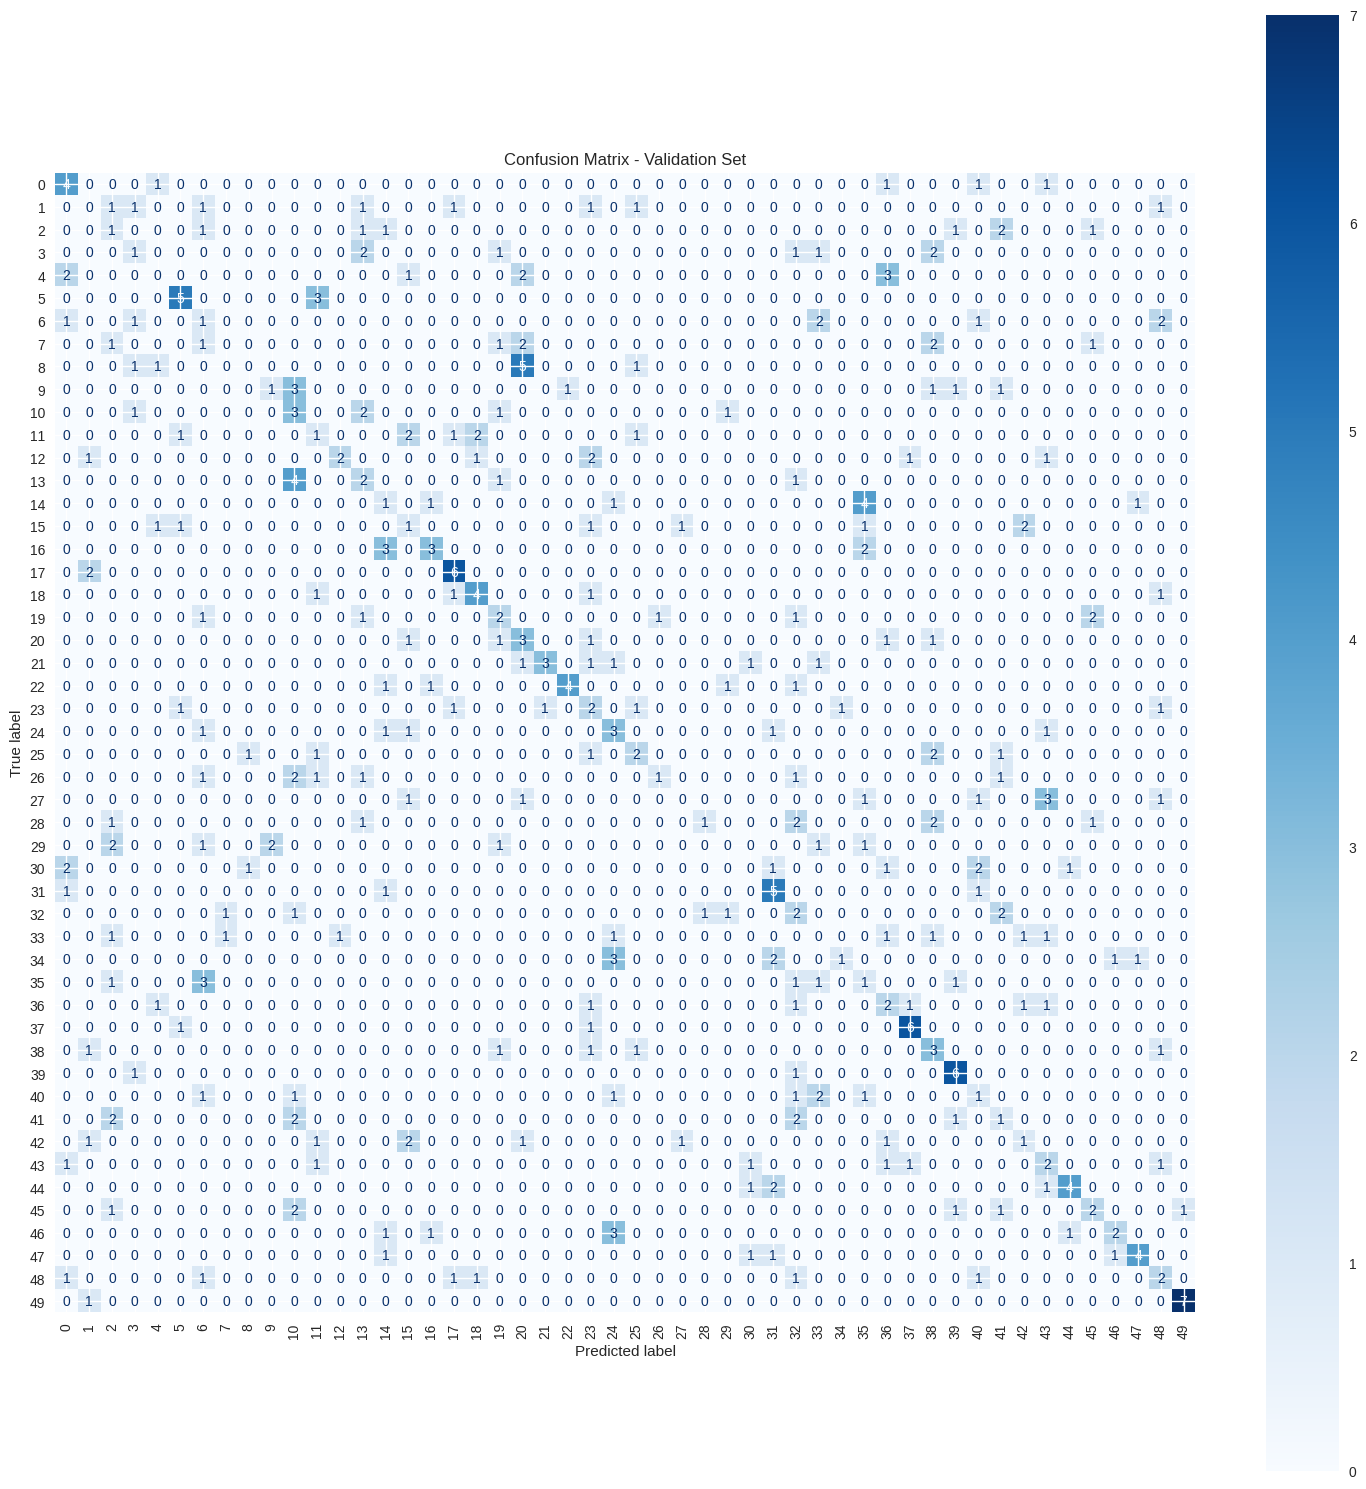

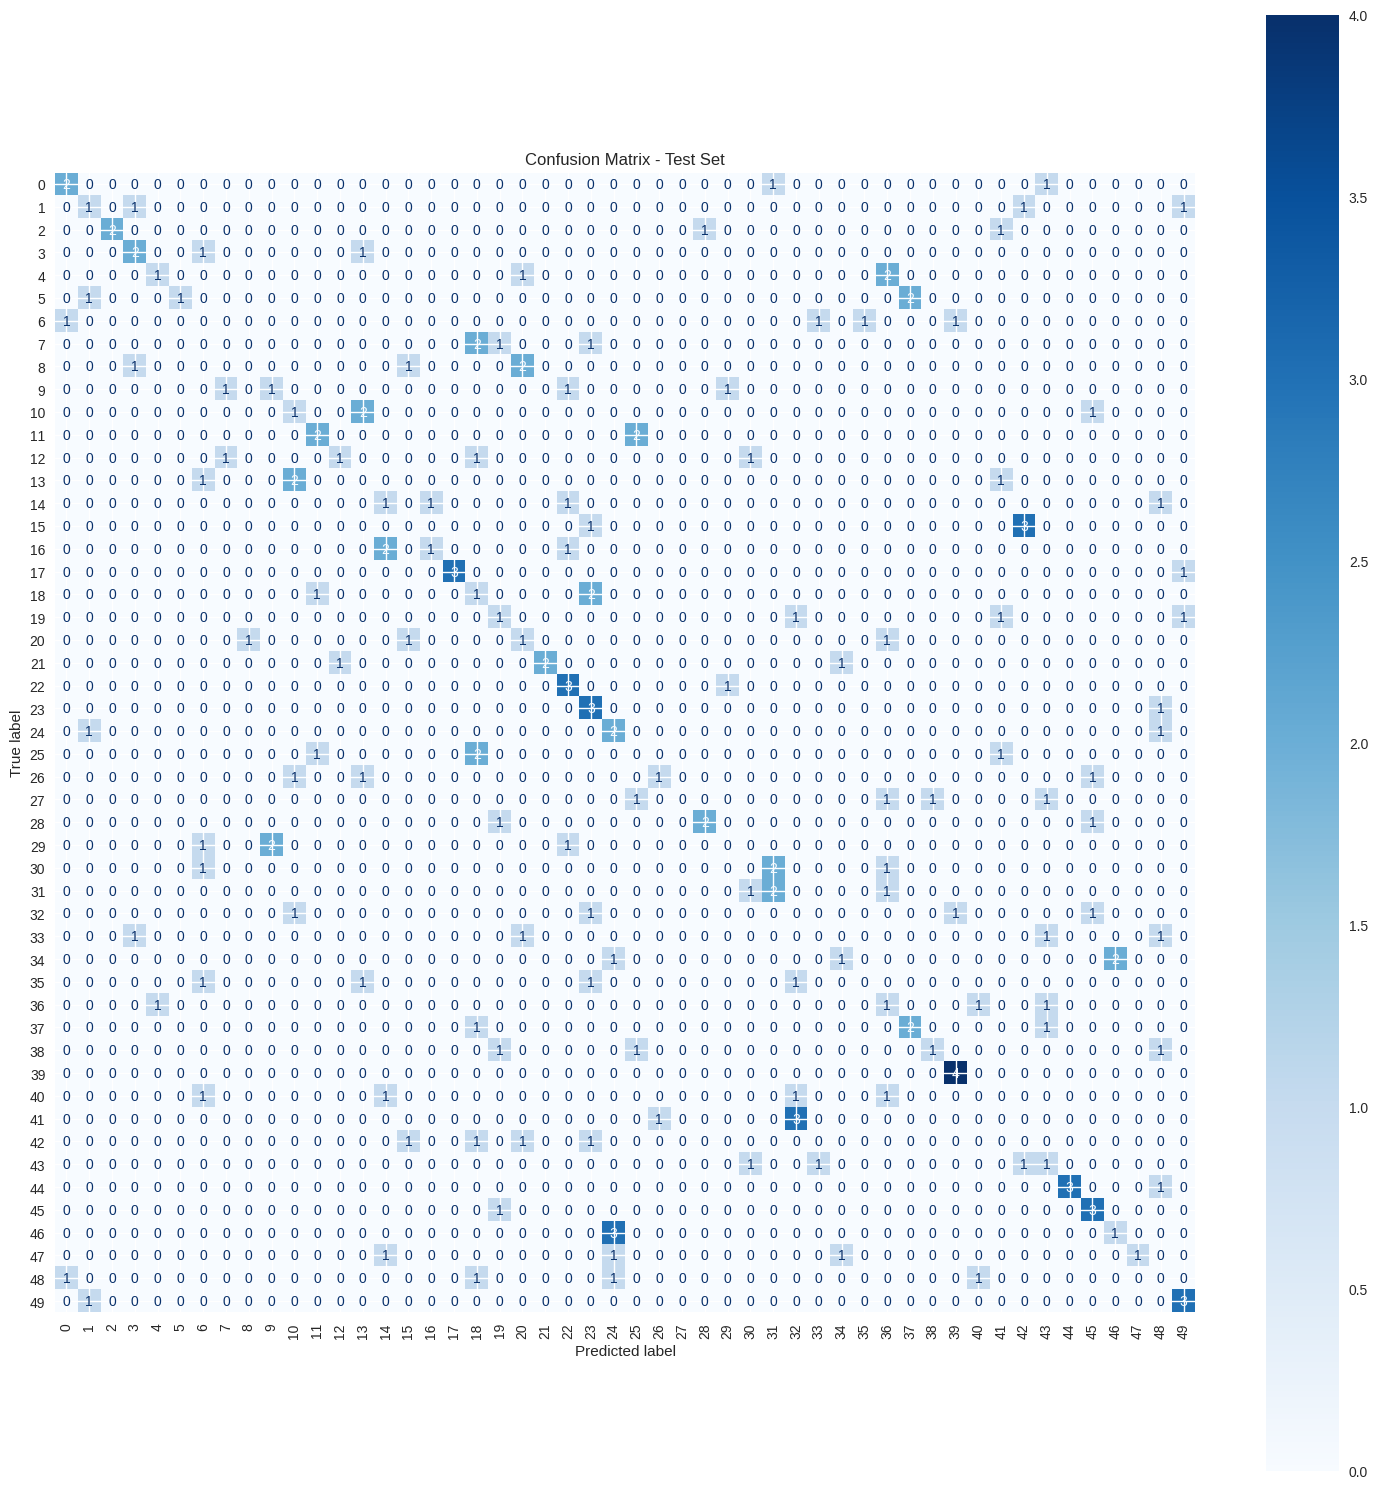

In [30]:
log_df_2D = pd.read_csv('training_2D_CNN.log')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(log_df_2D['epoch'], log_df_2D['accuracy'], label='Train')
plt.plot(log_df_2D['epoch'], log_df_2D['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log_df_2D['epoch'], log_df_2D['loss'], label='Train')
plt.plot(log_df_2D['epoch'], log_df_2D['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

#best validation accuracy
best_acc = np.max(history_2D.history['val_accuracy'])
best_acc_epoch = np.argmax(history_2D.history['val_accuracy'])
print('Best validation accuracy: ', best_acc)
print('Epoch for which we get the best validation accuracy: ', best_acc_epoch)

model_2D.load_weights('CNN_2D_model.h5')
[loss_test, acc_test] = model_2D.evaluate(X_test_exp, y_test, verbose=0)
print(f"Test loss: {loss_test}")
print(f"Test accuracy: {acc_test}")

possible_classes = np.arange(0, 50)

pred_val = model_2D.predict(X_val_exp)
pred_test = model_2D.predict(X_test_exp)

pred_val_classes = np.argmax(pred_val, axis=1)
pred_test_classes = np.argmax(pred_test, axis=1)

# Confusion matrix computation
cm_val = confusion_matrix(y_val, pred_val_classes)
cm_test = confusion_matrix(y_test, pred_test_classes)

# Confusion Matrix - Validation
fig_val, ax_val = plt.subplots(figsize=(15, 15))
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=possible_classes)
disp_val.plot(cmap=plt.cm.Blues, ax=ax_val, xticks_rotation=90)
ax_val.set_title('Confusion Matrix - Validation Set')
plt.tight_layout()
plt.show()

# Confusion Matrix - Test
fig_test, ax_test = plt.subplots(figsize=(15, 15))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=possible_classes)
disp_test.plot(cmap=plt.cm.Blues, ax=ax_test, xticks_rotation=90)
ax_test.set_title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

In [31]:
print('------------ Validation set --------------')
print(classification_report(y_val, pred_val_classes))

print('---------------- Test set ------------------')
print(classification_report(y_test, pred_test_classes))

------------ Validation set --------------
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         8
           1       0.00      0.00      0.00         8
           2       0.09      0.12      0.11         8
           3       0.17      0.12      0.14         8
           4       0.00      0.00      0.00         8
           5       0.56      0.62      0.59         8
           6       0.08      0.12      0.10         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         8
           9       0.33      0.12      0.18         8
          10       0.17      0.38      0.23         8
          11       0.11      0.12      0.12         8
          12       0.67      0.25      0.36         8
          13       0.18      0.25      0.21         8
          14       0.10      0.12      0.11         8
          15       0.11      0.12      0.12         8
          16       0.50      0.38     